In [1]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle
from utils import flat, trace
from tqdm import tqdm
import psutil
import torch
import gc
from itertools import product
from multiprocessing import Pool
from tqdm import tqdm
from data import RANZCRDataset
from model import RANZCRModel, kaggle_metric
from train import CFG
from utils import sigmoid
import torch.nn.functional as F

In [8]:
labels = []
for fname in tqdm(fnames):
    labels.append(joblib.load(os.path.join(base_path, fname))['labels'])

100%|██████████| 112120/112120 [13:58<00:00, 133.77it/s]


In [11]:
labels = np.stack(labels)

In [13]:
labels.mean(axis=0)

array([0.00097688, 0.01248823, 0.08512216, 0.00394854, 0.00802775,
       0.03491928, 0.05094716, 0.07504278, 0.4459039 , 0.4126182 ,
       0.00984483], dtype=float32)

In [5]:
base_path = '../../input/processed/nihchest'
fnames = os.listdir(base_path)
data_dir = '../../input/nihchest'
def save_one_data(fname):
    orig_path =os.path.join(base_path, fname)
    res = joblib.load(orig_path)
    res['img'] = cv2.imread(os.path.join(data_dir, fname[:-2]+'jpg'), cv2.IMREAD_GRAYSCALE)
    joblib.dump(res, orig_path, compress=1)
with Pool(32) as pool:
    list(tqdm(pool.imap_unordered(save_one_data, fnames), total=len(fnames)))

100%|██████████| 112120/112120 [01:39<00:00, 1121.77it/s]


In [15]:
base_path = '../../input/nihchest'
for f in os.listdir(base_path):
    cur = os.path.join(base_path, f)
    os.rename(cur, cur[:-3]+'jpg')

In [2]:
(features, labels, mask, anchor_dot_contrast, logits, logits_mask, exp_logits, log_prob) = joblib.load('tmp.jl')

In [16]:
train = pd.read_csv('../../input/kaggle/train.csv', index_col='StudyInstanceUID')
train_annotations = pd.read_csv('../../input/kaggle/train_annotations.csv', index_col='StudyInstanceUID')
sample_submission = pd.read_csv('../../input/kaggle/sample_submission.csv')
uids = train.index
folds = joblib.load('folds.jl')
label_cols = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
    'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
    'Swan Ganz Catheter Present'
]
img_path = '../../input/kaggle/train'
train_annotations['data'] = train_annotations['data'].apply(eval)
print(train.shape)
display(train.head())
print(train_annotations.shape)
display(train_annotations.head())

(30083, 12)


,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
StudyInstanceUID,,,,,,,,,,,,
1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
1.2.826.0.1.3680043.8.498.68286643202323212801283518367144358744,0,0,0,0,0,0,0,1,0,0,0,c31019814
1.2.826.0.1.3680043.8.498.10050203009225938259119000528814762175,0,0,0,0,0,0,0,0,0,1,0,207685cd1


(17999, 2)


,label,data
StudyInstanceUID,,
1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
1.2.826.0.1.3680043.8.498.72921907356394389969069434057117070831,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
1.2.826.0.1.3680043.8.498.11697104485452001927211929869950495038,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
1.2.826.0.1.3680043.8.498.87704688663091069148917694611057585294,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [69]:
uid = '1.2.826.0.1.3680043.8.498.93053605340693492468203536922883055634'
joblib.load(f'../../input/processed/data/{uid}.jl')

{'img': array([[ 71,  76, 102, ...,  98,  73,  66],
        [ 86,  94, 124, ..., 127,  98,  89],
        [134, 145, 180, ..., 176, 141, 130],
        ...,
        [104, 113, 146, ...,  60,  47,  42],
        [ 72,  78, 107, ...,  41,  30,  27],
        [ 56,  60,  85, ...,  32,  22,  21]], dtype=uint8),
 'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'masks': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int8)],
 'tips': [[1393, 1008]],
 'annotated': 1,
 'mask_exist_index': [9]}

dict_keys(['img', 'labels', 'masks', 'tips', 'annotated', 'mask_exist_index'])
[1487, 1279]


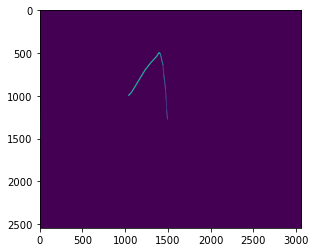

[1457, 1006]


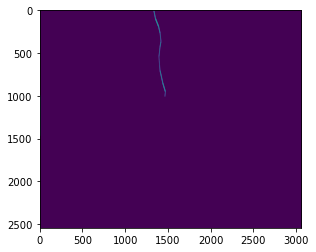

In [79]:
uid = train_annotations.index[0]
cur = joblib.load(f'../../input/processed/data/{uid}.jl')
print(cur.keys())
for mask, tips in zip(cur['masks'], cur['tips']):
    if mask.sum() != 0:
        print(tips)
        plt.imshow(mask.astype(float))
        plt.plot(tips, markersize=100)
        plt.show()

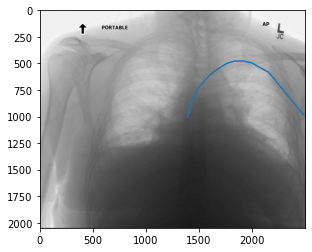

In [4]:
uid = '1.2.826.0.1.3680043.8.498.93053605340693492468203536922883055634'
img = cv2.imread(os.path.join(img_path, f'{uid}.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
masks = train_annotations.loc[[uid], 'data'].tolist()
fig = plt.figure()
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
for mask in masks:
    mask = np.array(mask)
    plt.plot(mask[:, 0], mask[:, 1])

In [27]:
def process(uid):
    img = joblib.load(f'../../input/processed/data/{uid}.jl')['img']
    return (img[50:100, 50:100].mean()+img[50:100, -100:-50].mean())/2
with Pool(32) as pool:
    res = list(tqdm(pool.imap(process, uids), total=len(uids)))
res = pd.Series(res, index=uids).sort_values(ascending=False)
for uid in res.index[:10]:
    img = joblib.load(f'../../input/processed/data/{uid}.jl')['img']
    plt.imshow(img, cmap='gray')
    plt.show()

100%|██████████| 30083/30083 [00:28<00:00, 1044.22it/s]


In [58]:
ett = [x for x in label_cols if x.startswith('ETT')]
print(train[ett].sum(axis=1).value_counts())
ngt = [x for x in label_cols if x.startswith('NGT')]
print(train[ngt].sum(axis=1).value_counts())
cvc = [x for x in label_cols if x.startswith('CVC')]
print(train[cvc].sum(axis=1).value_counts())

0    21626
1     8457
dtype: int64
0    21775
1     8263
2       45
dtype: int64
1    25758
2     3504
0      750
3       71
dtype: int64


In [ ]:
model = torch.load('../../model/v11/2048-b5/last.pth', map_location='cpu')
model = RANZCRModel(CFG(model['cfg']))
model.keys()